In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample

In [2]:
# Read the CSV file
df = pd.read_csv('diagnosed_cbc_data_v4.csv')

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


In [3]:
# Data Analysis

# 1. Identify unique diagnoses and their counts
diagnosis_counts = df['Diagnosis'].value_counts()
print("\nDiagnosis counts:")
diagnosis_counts


Diagnosis counts:


Healthy                           336
Normocytic hypochromic anemia     279
Normocytic normochromic anemia    269
Iron deficiency anemia            189
Thrombocytopenia                   73
Other microcytic anemia            59
Leukemia                           47
Macrocytic anemia                  18
Leukemia with thrombocytopenia     11
Name: Diagnosis, dtype: int64

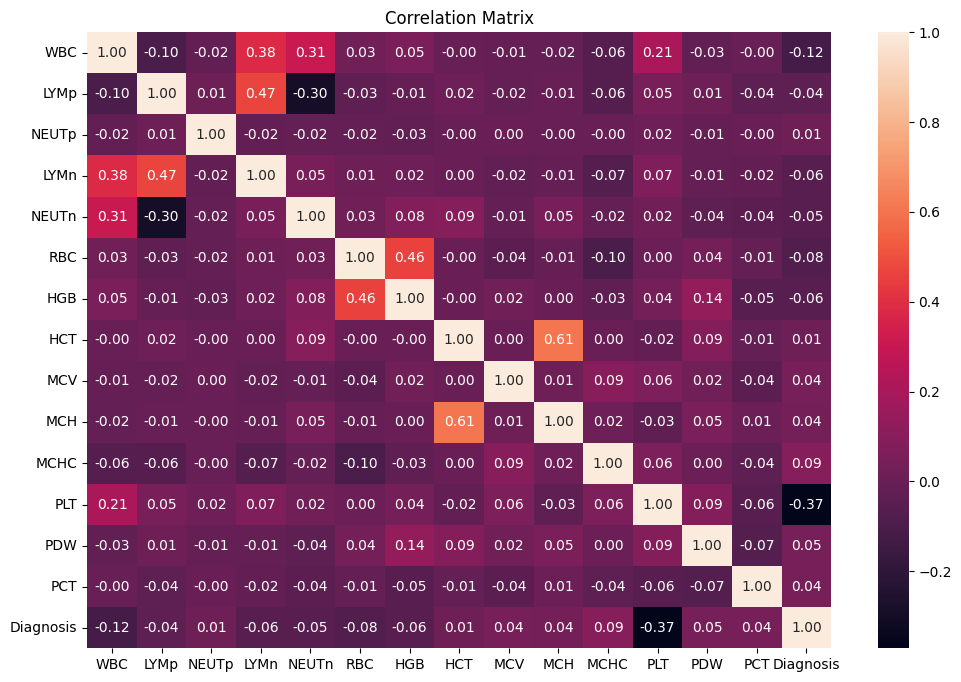

In [4]:
# 2. Analyze correlation between parameters and diagnosis
# Encode the 'Diagnosis' column to numeric values for correlation analysis
df_encoded = df.copy()
df_encoded['Diagnosis'] = df_encoded['Diagnosis'].astype('category').cat.codes
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Data Preprocessing
# Encode categorical Diagnosis column
df['Diagnosis'] = df['Diagnosis'].astype('category').cat.codes

# Split the data into features and target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Split the data into 80% training and 20% validation
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance by oversampling the training set
df_train_full = pd.concat([X_train_full, y_train_full], axis=1)
max_size = df_train_full['Diagnosis'].value_counts().max()

# Resample each class to match the size of the largest class
lst = [df_train_full]
for class_index, group in df_train_full.groupby('Diagnosis'):
    lst.append(group.sample(max_size-len(group), replace=True))
df_balanced = pd.concat(lst)

X_balanced = df_balanced.drop('Diagnosis', axis=1)
y_balanced = df_balanced['Diagnosis']

# Standardize the balanced features
scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)
X_val_scaled = scaler.transform(X_val)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)  # Number of components
X_balanced_pca = pca.fit_transform(X_balanced_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Convert target to categorical
y_balanced_categorical = to_categorical(y_balanced)
y_val_categorical = to_categorical(y_val)

# K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
all_y_test = []
all_y_pred = []

for train_index, test_index in kfold.split(X_balanced_pca):
    X_train, X_test = X_balanced_pca[train_index], X_balanced_pca[test_index]
    y_train, y_test = y_balanced_categorical[train_index], y_balanced_categorical[test_index]

    # Build the Neural Network model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(y_balanced_categorical.shape[1], activation='softmax')  # Number of classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy)

    # Predict the test set
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Store the results
    all_y_test.extend(np.argmax(y_test, axis=1))
    all_y_pred.extend(y_pred)

In [6]:
# Overall performance
print("\nK-Fold Cross-Validation Accuracy Scores:")
print(accuracy_scores)
print("\nMean Accuracy: ", np.mean(accuracy_scores))


K-Fold Cross-Validation Accuracy Scores:
[0.9752577543258667, 0.9297520518302917, 0.9483470916748047, 0.9462810158729553, 0.9359503984451294]

Mean Accuracy:  0.9471176624298095


In [7]:
# Classification report
print("\nClassification Report:")
print(classification_report(all_y_test, all_y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       269
           1       0.96      0.96      0.96       269
           2       0.96      1.00      0.98       269
           3       0.98      1.00      0.99       269
           4       0.97      1.00      0.99       269
           5       0.90      0.81      0.85       269
           6       0.92      0.90      0.91       269
           7       0.94      1.00      0.97       269
           8       0.93      0.97      0.95       269

    accuracy                           0.95      2421
   macro avg       0.95      0.95      0.95      2421
weighted avg       0.95      0.95      0.95      2421



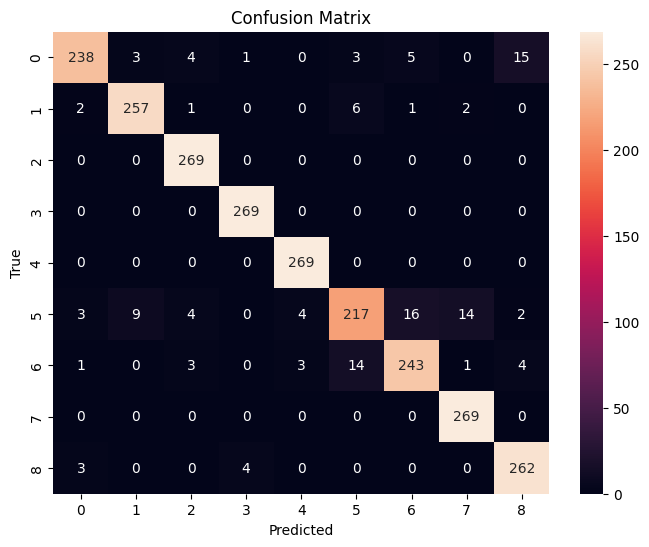

In [8]:
# Confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
# Evaluate the model on the validation set
model.fit(X_balanced_pca, y_balanced_categorical, epochs=50, batch_size=32, verbose=0)
y_val_pred = model.predict(X_val_pca)
y_val_pred = np.argmax(y_val_pred, axis=1)

# Validation performance
print("\nValidation Set Accuracy: ", np.mean(y_val_pred == y_val))
print("\nValidation Set Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Set Accuracy:  0.8754863813229572

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        67
           1       0.90      0.95      0.92        38
           2       0.44      0.44      0.44         9
           3       0.67      1.00      0.80         2
           4       1.00      0.75      0.86         4
           5       0.89      0.88      0.88        56
           6       0.95      0.96      0.95        54
           7       0.82      0.75      0.78        12
           8       0.67      0.93      0.78        15

    accuracy                           0.88       257
   macro avg       0.81      0.83      0.81       257
weighted avg       0.88      0.88      0.88       257



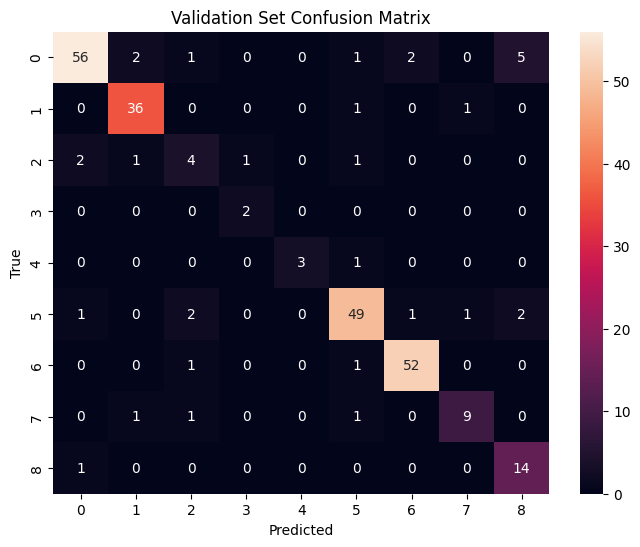

In [10]:
# Validation set confusion matrix
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d')
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()